# 🏠House Price Prediction with Scikit Learn Random Forrest

This notebook serves as an example of how to train a regression model using scikit learn. The data for this notebook is from the [House Prices: Advanced Regression Techniques](https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques) Kaggle competition. Model training code is loosley based on [this submission](https://www.kaggle.com/code/jayakishan225/predicting-house-prices-with-ml) by Jayakishan Minnekanti.

## 🎯Objective

The object of this competition is to predict the price a home will sell for given 79 different features describing many different aspects of the home.

## ⚙️Setup

In order to use this notebook you will need to download the `train.csv` and `test.csv` files from Kaggle and place them in the `data` directory located at `../data`

## 📦 1. Import Libraries

It's best practice to import all of your libraries at the top of your notebook just like a regular Python script rather than throughout the notebook itself. This way you can quickly tell at a glace the dependencies of the notebook, it will also be easier to convert the notebook to a script in the future if needed. 😉

The libraries we will be using are:

* **Pandas & Numpy** - The typical Python scientific stack
* **Scikit-learn** - For data preprocessing and modeling
* **Plotly** - For data visualization
* **MLFlow** - For model experiment tracking and distribution
* **JSON** - For output data wrangling

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

import plotly.express as px

import mlflow
from mlflow.models import infer_signature

import json

## 📂 2. Load Dataset & Visulaize our Target Variable

We load our dataset using Pandas and visualize our target variable using [Plotly Express](https://plotly.com/python/plotly-express/) for ease of use. Notice our target has a noticeable right-skew

In [2]:
# Load Dataset

# Load training and test datasets
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')

# Display shapes
print(f"Train Shape: {train.shape}")
print(f"Test Shape: {test.shape}")

# Preview the data
train.head()

Train Shape: (1460, 81)
Test Shape: (1459, 80)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


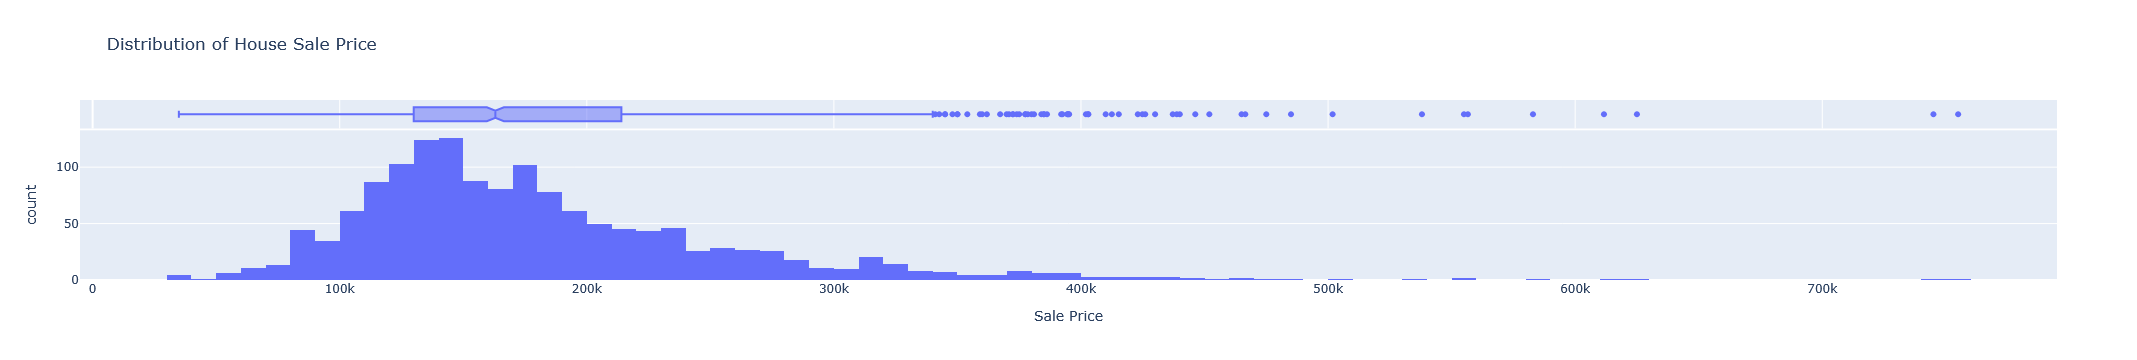

In [3]:
# Create a histogram chart using Plotly
fig = px.histogram(
    train, 
    x='SalePrice',
    labels= {'SalePrice': 'Sale Price'},
    title='Distribution of House Sale Price',
    marginal='box'
)
fig.show()

## ❌ 3. Visualize Null Values and Remove High Percentage Null Columns

Next, it's always good to check if we have any column has a high percentage of null values and remove them as they won't provide much information to the model. Here we remove a column if it is more than 30% null.

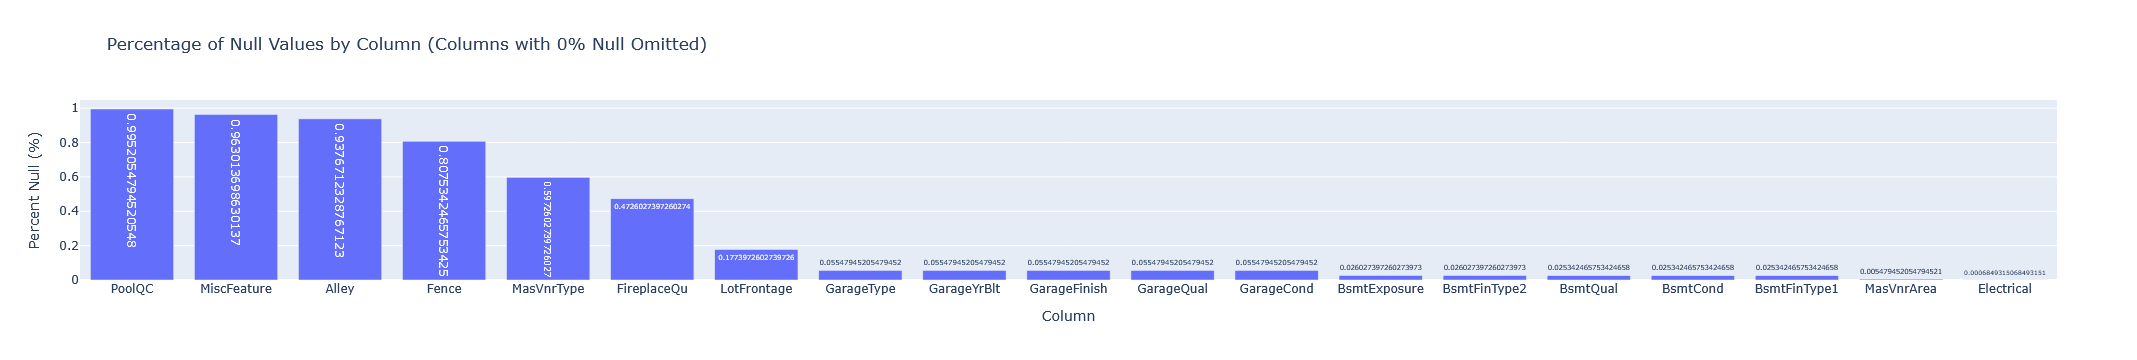

In [4]:
# Calculate percentage of null values for each column
null_percentages = train.isnull().mean()
null_percentages = null_percentages.reset_index()
null_percentages.columns = ['column', 'percent_null']
null_percentages = null_percentages[null_percentages.percent_null > 0]
null_percentages.sort_values(by='percent_null', inplace=True, ascending=False)

# Create a bar chart using Plotly
fig = px.bar(
    null_percentages,
    x='column',
    y='percent_null',
    title='Percentage of Null Values by Column (Columns with 0% Null Omitted)',
    labels={'percent_null': 'Percent Null (%)', 'column': 'Column'},
    text='percent_null'
)

fig.show()

In [5]:
# Drop columns with more than 30% missing values
drop_cols = null_percentages[null_percentages.percent_null > 0.3].column
train_df = train.drop(columns=drop_cols)

## ✂️4. Create Train-Test Split & Visualize Feature Types

With our dataset clean we can now create our Train-Test split. We can also check to see which features are numeric and which are categorical so we know what processing steps we need to complete on each of them.

In [6]:
# Remove ID column as it won't be used for training
train_df.drop(columns=['Id'], axis=1, inplace=True)

# Define features and target
X = train_df.drop(['SalePrice'], axis=1)
y = train_df['SalePrice']

In [7]:
# Train-Test Split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
numeric_columns = X_train.select_dtypes(include=['int64', 'float64']).columns
categorical_columns = X_train.select_dtypes(include=['object']).columns

print(f'Numeric columns: {numeric_columns}')
print(f'Categorical columns: {categorical_columns}')

Numeric columns: Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold'],
      dtype='object')
Categorical columns: Index(['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating',
       'Heat

## 🧠 5. Feature Engineering

Next we define our transformers for feature engineering. We can break our transfomers into two types:

* **Imputation** - For the remaining columns that could be null, we need to equip our model with a way to handle them.
    * For our `numeric_columns` we will fill in any missing value with the `median` of that column.
    * For our `categorical_columns` we will fill in any missing value with the `most_frequent` value in that column.
    * Any remaining columns that are provided to this transformer we will `drop`.
    * Finally, by default the `ColumnTransformer` appends the name of the transformation to the outputted column, we can disable this behavior by setting `verbose_feature_names_out` to `False`.
* **Encoding** - For our `categorical_columns` we'd also liked to apply [One Hot Encoding](https://www.geeksforgeeks.org/ml-one-hot-encoding/) to them.
    * We don't want `sparse_output` as this can cause errors when we train our model so we set it to `False`.
    * We also want our model to gracefully handle unknown values of a feature that were not present in our training data without throwing an error so we set `handle_unknown` to `ignore`.
    * Since this will be the second transformation we apply to our data and it will be on a subset of the columns we'd like any remaining columns to be `passthrough`.
    * Finally, just as before we don't want the name of the transformation appened to the output so we set `verbose_feature_names_out` to `False`.

In [9]:
impute_transformer = ColumnTransformer(
    [
        (
            'median_imputer', 
            SimpleImputer(missing_values=np.nan, strategy='median'),
            numeric_columns
        ),
        (
            'mode_imputer',
            SimpleImputer(missing_values=np.nan, strategy='most_frequent'),
            categorical_columns
        )
    ],
    remainder='drop',
    verbose_feature_names_out=False
)

In [10]:
encode_transformer = ColumnTransformer(
    [
        (
            'categorical_one_hot', 
            OneHotEncoder(sparse_output=False, handle_unknown='ignore'),
            categorical_columns
        )
    ],
    remainder='passthrough',
    verbose_feature_names_out=False
)

## 🏗️ 6. Create Model Pipeline

With our feature transformers created we next create a `Pipeline` that contains both our model artifact and the preprocessing steps it needs. 

* In order to chain multiple `ColumnTransformers` on top of each other we must set the output `transform` to `pandas`


📌 **Note:** This style of using a [Pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) in combination with a [Column Transformer](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html) is rarely shown in examples you will find online (which is a shame!). It is extremly powerful as it allows us to bundle the transformantions a model needs directly with the model itself and treat them as one unit, in a sense the transformations become *part* of the model. This becomes extremly useful when the model is deployed.

In [11]:
model = RandomForestRegressor(n_estimators=100, random_state=42)

In [12]:
pipeline = Pipeline(
    [
        ('impute', impute_transformer),
        ('encode', encode_transformer),
        ('model', model)
    ]
).set_output(transform='pandas')
pipeline

Pipeline(steps=[('impute',
                 ColumnTransformer(transformers=[('median_imputer',
                                                  SimpleImputer(strategy='median'),
                                                  Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath...
       'Exterior2nd', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional',
       'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive',
       'SaleType', 'SaleCondition'],
      dtype='object'))],
                                   verbose_feature_names_out=False)),
                ('model', RandomForestRegressor(random_state=42))])

## 📉 7. Run Pipeline Experiment

With our Pipeline created we can now execute an experiment!

* We use [MLFlow](https://mlflow.org/) to track our experiment
* Any model metrics are caputed with `mlflow.log_metric()`
* Any graphs/figures are captured with `mlflow.log_figure()`
* The model itself is captured with `mlflow.sklearn.log_model()`

📌 **Note:** Make sure the MLFlow Local Server is running before executing the code! `mlflow server --host 127.0.0.1 --port 8080`

In [13]:
# Create a new MLflow Experiment
mlflow.set_tracking_uri(uri='http://127.0.0.1:8080')
mlflow.set_experiment('Housing Price Prediction')

<Experiment: artifact_location='mlflow-artifacts:/370087510810227321', creation_time=1748227930745, experiment_id='370087510810227321', last_update_time=1748227930745, lifecycle_stage='active', name='Housing Price Prediction', tags={}>

In [14]:
# Start an MLflow run
with mlflow.start_run():
    pipeline.fit(X_train, y_train)
    
    y_pred = pipeline.predict(X_val)
    
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    mae = mean_absolute_error(y_val, y_pred)
    fig = px.scatter(
        x=y_val, 
        y=y_pred, 
        labels={
            'x': 'Actual House Sale Price',
            'y': 'Predicted House Sale Price'
        },
        title='Actual vs Predicted House Sale Price'
    )

    # Log metrics and figures
    mlflow.log_metric('RMSE', rmse)
    mlflow.log_metric('MAE', mae)
    mlflow.log_figure(fig, 'actual_vs_predicted.html')

    # Infer the model signature
    signature = infer_signature(train[X_train.columns], y_pred)
    
    # Log the model
    model_info = mlflow.sklearn.log_model(
        sk_model=pipeline,
        artifact_path='model',
        signature=signature,
        input_example=X_train
    )
    
print("Random Forest RMSE:", rmse)
print("Random Forest MAE:", mae)

/home/overlord/Documents/PythonProjects/DataDelver/modern-ml-microservices/.venv/lib/python3.13/site-packages/mlflow/types/utils.py:452: UserWarning:

Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.

2025/05/26 18:00:36 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


🏃 View run adorable-sloth-941 at: http://127.0.0.1:8080/#/experiments/370087510810227321/runs/e239594946d54f3ab52b474396026f28
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/370087510810227321
Random Forest RMSE: 28413.021988638255
Random Forest MAE: 17463.92294520548


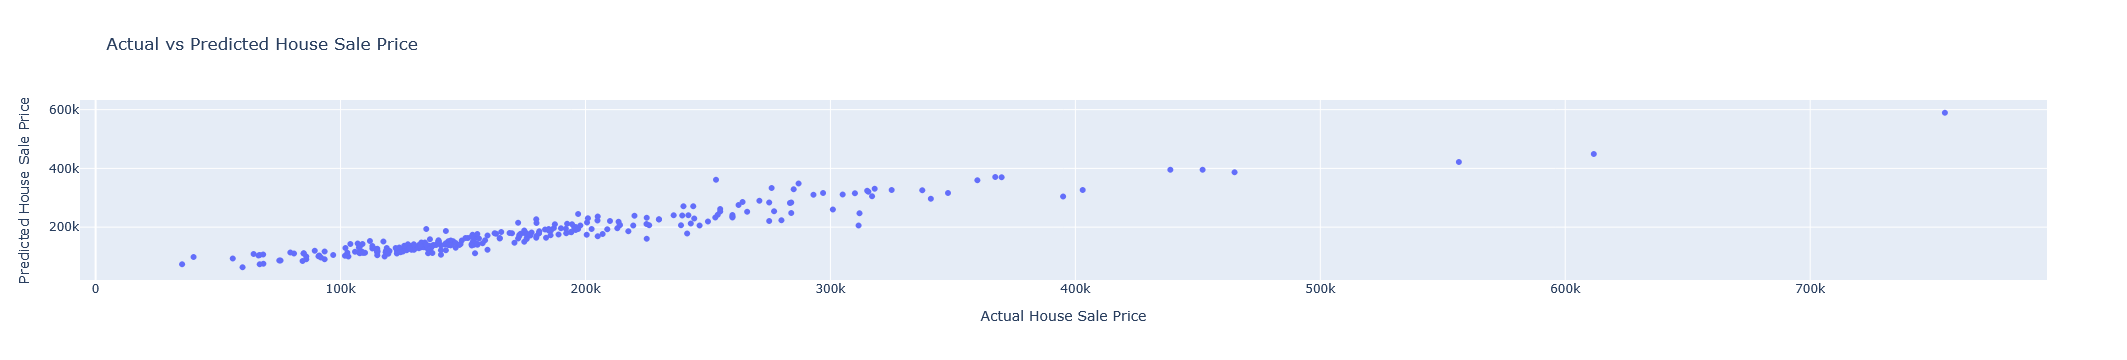

In [15]:
fig.show()

## 🤖 8. Use the Pipeline to Make Predictions on the Test Set!

Now that our pipeline has been fitted, we can use it to make predictions on the test set!

* Notice how we didn't have to transform the test set at all to make predictions when we call `predict()`, all of the neceissary transformations are built into the pipeline!

In [16]:
test_submit = pipeline.predict(test)

In [17]:
# Create a histogram chart using Plotly
fig = px.histogram(
    x=test_submit,
    labels= {'x': 'Predicted Sale Price'},
    title='Distribution of Predicted House Sale Price on Test Set',
    marginal='box'
)
fig.show()

## 🪄 9. Format Sample of Test Set for HTTP Precition

The following snippet of code formats a sample of the test set into the schema expected by MLFlow Server.

* We serialize and then deserialize the Dataframe to JSON to ensure that nulls are correctly encoded.

In [18]:
json.dumps({
    "dataframe_split": json.loads(test.head(5).to_json(orient="split"))
})

'{"dataframe_split": {"columns": ["Id", "MSSubClass", "MSZoning", "LotFrontage", "LotArea", "Street", "Alley", "LotShape", "LandContour", "Utilities", "LotConfig", "LandSlope", "Neighborhood", "Condition1", "Condition2", "BldgType", "HouseStyle", "OverallQual", "OverallCond", "YearBuilt", "YearRemodAdd", "RoofStyle", "RoofMatl", "Exterior1st", "Exterior2nd", "MasVnrType", "MasVnrArea", "ExterQual", "ExterCond", "Foundation", "BsmtQual", "BsmtCond", "BsmtExposure", "BsmtFinType1", "BsmtFinSF1", "BsmtFinType2", "BsmtFinSF2", "BsmtUnfSF", "TotalBsmtSF", "Heating", "HeatingQC", "CentralAir", "Electrical", "1stFlrSF", "2ndFlrSF", "LowQualFinSF", "GrLivArea", "BsmtFullBath", "BsmtHalfBath", "FullBath", "HalfBath", "BedroomAbvGr", "KitchenAbvGr", "KitchenQual", "TotRmsAbvGrd", "Functional", "Fireplaces", "FireplaceQu", "GarageType", "GarageYrBlt", "GarageFinish", "GarageCars", "GarageArea", "GarageQual", "GarageCond", "PavedDrive", "WoodDeckSF", "OpenPorchSF", "EnclosedPorch", "3SsnPorch", "S